# 1. Configuración inicial y Carga de imágenes

## 1.1 Instalación de librerias necesarias

In [53]:
!pip install tensorflow opencv-python matplotlib

You should consider upgrading via the 'C:\Users\dulibarri\Documents\Programación\python\ImageClassification\imageClassificationvenv.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [54]:
import tensorflow as tf
import os

## 1.2 Filtración de imágenes
Se filtraran las imágenes que no podamos usar en nuestro modelo

In [55]:
import cv2
import imghdr
image_directory = 'images'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [56]:
# Cantidad de imágenes de Violines antes de la filtración
len(os.listdir(os.path.join(image_directory, 'fiddle')))

224

In [57]:
# Cantidad de imágenes de Guitarras antes de la filtración
len(os.listdir(os.path.join(image_directory, 'guitar')))

206

In [58]:
# Esta parte del codigo verifica que las imágenes puedan ser usadas por OpenCv y tengan
# las extensiones permitidas, las imágenes que no cumplan las características se eliminaran
for image_class in os.listdir(image_directory):
    for image in os.listdir(os.path.join(image_directory, image_class)):
        image_path = os.path.join(image_directory, image_class, image)
        try:
            # Checa que podamos cargar la imágen en opencv
            img = cv2.imread(image_path)
            # Checa que nuestra imagen tenga las extension permitida
            img_ext = imghdr.what(image_path)
            if img_ext not in image_extensions:
                print(f'La extención {img_ext} no esta permitida')
                os.remove(image_path)
        except Exception as e:
            print(f'La imagen {image_path} tiene un problema')
            os.remove(image_path)

In [59]:
# Cantidad de imágenes de violines después de la filtración
len(os.listdir(os.path.join(image_directory, 'fiddle')))

224

In [60]:
# Cantidad de imágenes de guitarras después de la filtración
len(os.listdir(os.path.join(image_directory, 'guitar')))

206

## 1.3 Cargar imagenes

In [61]:
import numpy as np
from matplotlib import pyplot as plt
# cargar imagenes, el método se encarga de dividir nuestras imagenes de forma aleatoria en bloques de 32
images = tf.keras.utils.image_dataset_from_directory('images')

Found 430 files belonging to 2 classes.


In [62]:
image_iterator = images.as_numpy_iterator()

In [63]:
# nos permite cambiar el conjunto de imagenes que estamos usando
# label 0 = fiddle
# label 1 = guitar
batch = image_iterator.next()

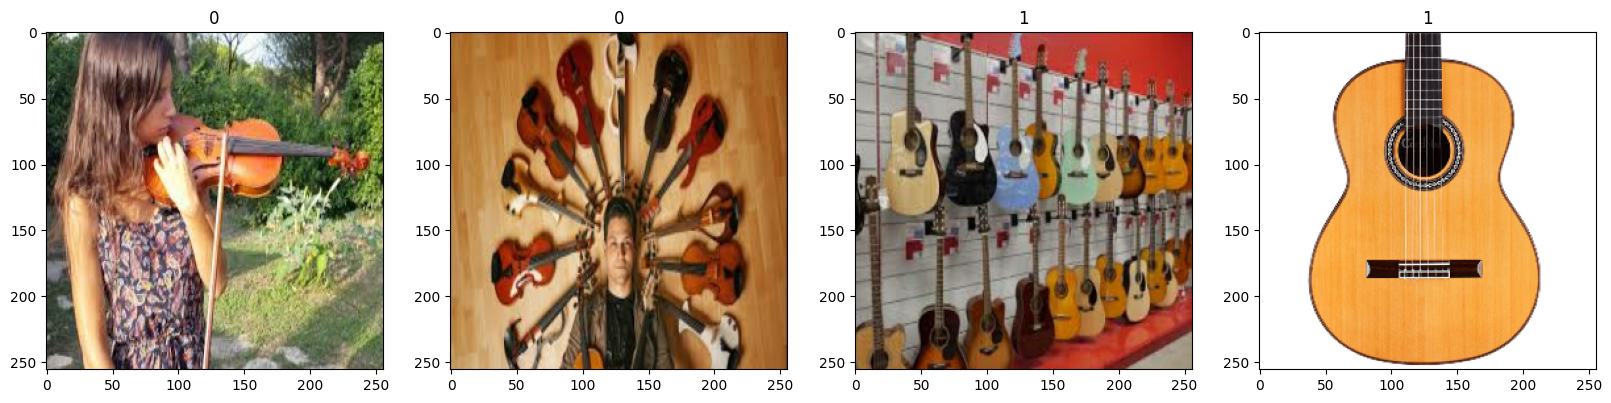

In [64]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocesamiento de imágenes

## 2.1 Escalamiento de las imágenes

In [65]:
# Vamos a cambiar la representación de los valores numéricos de las imagenes de (0 - 255) a (0 - 1)
images = images.map(lambda x, y: (x/255, y))

## 2.2 Dividir las imágenes

In [66]:
len(images)

14

In [67]:
train_size = int(len(images)*.7)
validation_size = int(len(images)*.2)+1
test_size = int(len(images)*.1)+1

In [68]:
train_size + validation_size + test_size

14

In [69]:
# train_data -> Imágenes que se usaran para entrenar el modelo
train_data = images.take(train_size)
# validation_data -> Imágenes que se usaran para evaluar el modelo mientras se entrena
validation_data = images.skip(train_size).take(validation_size)
# test_data -> Imágenes que el modelo nunca ha visto
test_data = images.skip(train_size + validation_size).take(test_size)

# 3. Modelo

## 3.1 Construcción del modelo de Deep Learning

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

Para nuestro modelo utilizaremos el modelo sequential de keras en vez del modelo functional, esto se debe a que el modelo sequential es muy bueno cuando trabajamos con solo una entrada y una salida, si nuestro objetivo es que el modelo recibiera varias entradas y tuviera varias salidas el modelo por el que se hubiera obtado sería el functional

In [71]:
model = Sequential()

Lo primero que haremos con nuestro modelo es que añadiremos una convolución con x filtros los cuales nos ayudan a extraer la información más relevante de las imágenes, lo siguiente que indicamos es el tamaño de nuestros filtros el cual es de 3x3 pixeles, después indicamos cuantos pixeles se va a ir moviendo que en este caso es 1; esta arquitectura es la que mejor me funciono pero se podrían cambiar los valores y ver como se comporta el modelo.
Después pasamos un MaxPooling el cuál nos ayudara a escanear todos los outputs y condensara la información.
Al final pasamos una activación sigmoide para que el modelo nos regrese valores entre 0 o 1 y con esto podamos clasificar nuestras imágenes.

In [72]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [73]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

## 3.2 Entrenamiento del modelo

In [75]:
log_directory = 'logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [77]:
hist = model.fit(train_data, epochs = 20, validation_data = validation_data, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 22s 1s/step - loss: 1.4967 - accuracy: 0.5069 - val_loss: 0.6928 - val_accuracy: 0.4792
Epoch 2/20
9/9 [==============================] - 12s 1s/step - loss: 0.6896 - accuracy: 0.5660 - val_loss: 0.6866 - val_accuracy: 0.7292
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 0.6794 - accuracy: 0.6458 - val_loss: 0.6586 - val_accuracy: 0.6146
Epoch 4/20
9/9 [==============================] - 11s 1s/step - loss: 0.6516 - accuracy: 0.6458 - val_loss: 0.6311 - val_accuracy: 0.6979
Epoch 5/20
9/9 [==============================] - 11s 1s/step - loss: 0.6004 - accuracy: 0.7083 - val_loss: 0.6002 - val_accuracy: 0.6667
Epoch 6/20
9/9 [==============================] - 13s 1s/step - loss: 0.5482 - accuracy: 0.7500 - val_loss: 0.4765 - val_accuracy: 0.7604
Epoch 7/20
9/9 [==============================] - 12s 1s/step - loss: 0.4770 - accuracy: 0.7847 - val_loss: 0.4761 - val_accuracy: 0.7812
Epoch 8/20
9/9 [==================

## 3.3 Rendimiento

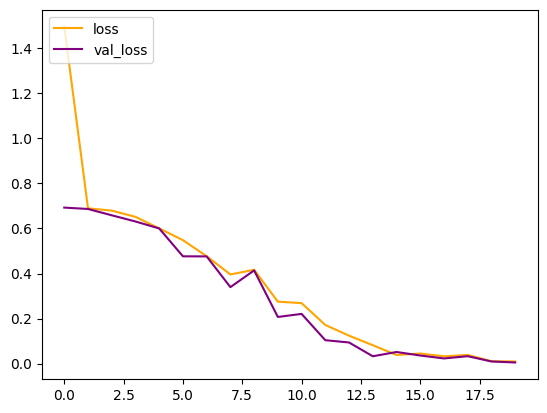

In [78]:
figure = plt.figure()
plt.plot(hist.history['loss'], color='orange', label='loss')
plt.plot(hist.history['val_loss'], color='purple', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

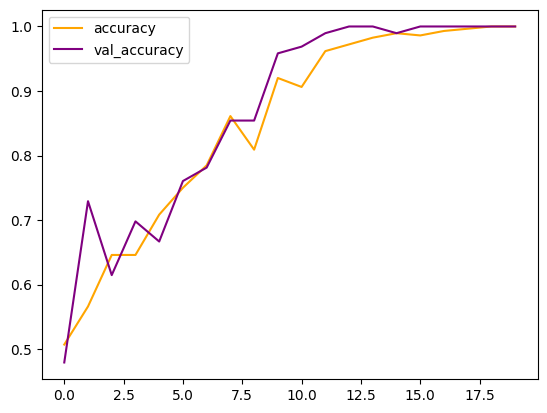

In [79]:
figure = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='purple', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluación del Modelo

In [80]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [81]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [82]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 136ms/step


In [83]:
print(f'Precision: {precision.result().numpy()}\nRecall: {recall.result().numpy()}\nAccuracy: {accuracy.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


# 5. Genera tu predicción

In [84]:
from urllib.request import urlopen

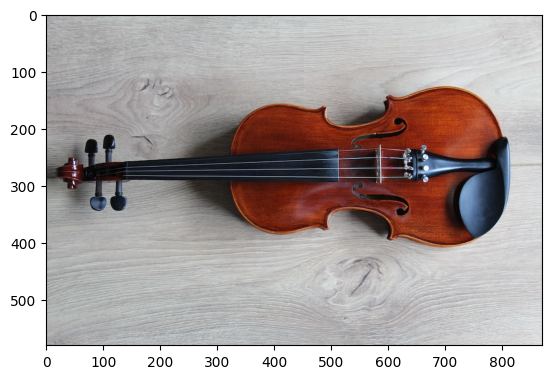

In [91]:
# Para poder probar con cualquier imágen de la web cambiar el url de la imágen por la deseada
img_link = "https://images.unsplash.com/photo-1612225330812-01a9c6b355ec?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=870&q=80"
req = urlopen(img_link)
readFlag=cv2.IMREAD_COLOR
image = np.asarray(bytearray(req.read()), dtype="uint8")
image = cv2.imdecode(image, readFlag)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [92]:
rezise = tf.image.resize(image, (256, 256))
yhat = model.predict(np.expand_dims(rezise/256, 0))
if yhat > 0.5:
  print(f'Predicted: Guitar {yhat}')
else:
  print(f'Predicted: Fiddle {yhat}')

1/1 [==============================] - 0s 32ms/step
Predicted: Fiddle [[0.00221494]]
